James Fisher
9/1/2024
ANA680

Final Project: Predicting Medicare Provider Use of Annual Wellness Visits

To predict provider decile of using Annual Wellness Visits compared to all other individual providers across all 50 U.S. states who directly billed Medicare in 2022 and for whom credential type, rural-urban coding, and preventive care data were available in the CMS Public Use File for calendar year 2022 available from https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners. Two source files were pulled from this location and a composite dataframe created with variables of interested (see FisherJ_ANA680_FinalProject_DataPrep.ipynb).

Machine learning is ideal for this task, because of the 

In this Notebook, I construct, fine tune, and assess the final model.

In [20]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle as pkl



In [4]:
#import data
data = pd.read_csv('C:/Users/unkno/Desktop/MS Data Science/Class 9 - ANA680/Week 4/fp/prepared_data.csv')

##temporary
#drop rows where Rndrng_Prvdr_State_Abrvtn is 'PR', 'GU', 'VI', 'MP', 'AS', 'MH', 'PW', 'FM', 'AS', 'DC' because these are not US states
data = data[~data.Rndrng_Prvdr_State_Abrvtn.isin(['PR', 'GU', 'VI', 'MP', 'AS', 'MH', 'PW', 'FM', 'AS', 'DC', 'AA', 'AE', 'AP', 'XX', 'ZZ'])]


In [5]:
#recode so that M = 0 and F = 1 for Rndrng_Prvdr_Gndr (provider gender)
data['Rndrng_Prvdr_Gndr'] = data['Rndrng_Prvdr_Gndr'].replace('M', 0)
data['Rndrng_Prvdr_Gndr'] = data['Rndrng_Prvdr_Gndr'].replace('F', 1)

#replace NaN values with 0 (no services rendered, values were NaN on import because they were blank in the original data)
data.fillna(0, inplace=True)

#print columns
print(data.columns)

#print head
print(data.head())

Index(['Rndrng_NPI', 'Rndrng_Prvdr_Gndr', 'Rndrng_Prvdr_RUCA',
       'Rndrng_Prvdr_State_Abrvtn', 'Tot_HCPCS_Cds', 'Tot_Benes', 'Tot_Srvcs',
       'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Pymt_Amt', 'Drug_Tot_HCPCS_Cds',
       'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Pymt_Amt', 'Med_Tot_Benes',
       'Med_Tot_Srvcs', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt',
       'Bene_Age_65_74_Cnt', 'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt',
       'Bene_Feml_Cnt', 'Bene_Male_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt',
       'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Mood_V2_Pct',
       'Bene_CC_PH_Asthma_V2_Pct', 'Bene_CC_PH_Afib_V2_Pct',
       'Bene_CC_PH_Cancer6_V2_Pct', 'Bene_CC_PH_CKD_V2_Pct',
       'Bene_CC_PH_COPD_V2_Pct', 'Bene_CC_PH_Diabetes_V2_Pct',
       'Bene_CC_PH_HF_NonIHD_V2_Pct', 'Bene_CC_PH_Hyperlipidemia_V2_Pct',
       'Bene_CC_PH_Hypertension_V2_Pct', 'Bene_CC_PH_IschemicHeart_V2_Pct',
       'Bene_CC_PH_Arthritis_V2_Pct', 'Bene_Avg_Risk_Scre', 'Bene_Pct_DELIS',
       'has_MD', 'has_DO', 'is_NP', 'is

In [6]:
#split data into target and features
from sklearn.model_selection import train_test_split
X = data.drop('Rndrng_Prvdr_Gndr', axis=1)
y = data['Rndrng_Prvdr_Gndr']

#drop primary key of dataset
X = X.drop('Rndrng_NPI', axis=1)

#flatten y into a 1D array
y = y.to_numpy().ravel()

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

In [7]:
##FEATURE VARIABLE ENCODING & SCALING

#identify continuous and categorical variables in joined dataset
continuous_features = ['Tot_HCPCS_Cds', 'Tot_Benes', 'Tot_Srvcs', 'Tot_Sbmtd_Chrg', 'Tot_Mdcr_Pymt_Amt', 'Drug_Tot_HCPCS_Cds', 'Drug_Sbmtd_Chrg', 'Drug_Mdcr_Pymt_Amt',
             'Med_Tot_Benes', 'Med_Tot_Srvcs', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt', 'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt', 
             'Bene_Male_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt', 'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Mood_V2_Pct', 'Bene_CC_PH_Asthma_V2_Pct', 'Bene_CC_PH_Hyperlipidemia_V2_Pct', 
             'Bene_CC_PH_Afib_V2_Pct', 'Bene_CC_PH_Cancer6_V2_Pct', 'Bene_CC_PH_CKD_V2_Pct', 'Bene_CC_PH_COPD_V2_Pct', 'Bene_CC_PH_Diabetes_V2_Pct', 'Bene_CC_PH_HF_NonIHD_V2_Pct',
             'Bene_CC_PH_Hypertension_V2_Pct', 'Bene_CC_PH_IschemicHeart_V2_Pct', 'Bene_CC_PH_Arthritis_V2_Pct', 'Bene_Avg_Risk_Scre', 'Bene_Pct_DELIS', 'total_flu_vaccines', 
             'total_pneumo_vaccines', 'total_hepB_vaccines', 'total_tetanus_vaccines', 'total_awv', 'total_mammographies', 'total_crc_screenings',
             'total_prostate_screenings']
categorical_features = ['Rndrng_Prvdr_RUCA', 'Rndrng_Prvdr_State_Abrvtn', 'has_MD', 'has_DO', 'is_NP', 'is_PA', 'flag_not_MD_DO_NP_PA']
#'Rndrng_Prvdr_Gndr' (categorical) is target variable

#initialize scaler and encoder
scaler = StandardScaler()
label_encoders = {feature: LabelEncoder() for feature in categorical_features}

#scale continuous features
X_train_continuous = scaler.fit_transform(X_train[continuous_features])
X_test_continuous = scaler.transform(X_test[continuous_features])

#encode categorical features
X_train_categorical = X_train[categorical_features].copy()
X_test_categorical = X_test[categorical_features].copy()

for feature in categorical_features:
    X_train_categorical[feature] = label_encoders[feature].fit_transform(X_train[feature])
    X_test_categorical[feature] = label_encoders[feature].transform(X_test[feature])

#concatenate processed continuous and categorical features back together
X_train_processed = pd.concat([pd.DataFrame(X_train_continuous, columns=continuous_features),
                               X_train_categorical.reset_index(drop=True)], axis=1)

X_test_processed = pd.concat([pd.DataFrame(X_test_continuous, columns=continuous_features),
                              X_test_categorical.reset_index(drop=True)], axis=1)


In [8]:
#compare number of columns in training and testing data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(652295, 49)
(163074, 49)
(652295,)
(163074,)


In [11]:
#initialize and fit Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=66, n_jobs=-1)
model.fit(X_train_processed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=66)

In [12]:
#predict on test data
y_pred = model.predict(X_test_processed)

#calculate accuracy
acc = accuracy(y_test, y_pred)
print(f'Accuracy: {acc}')

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.7525785839557502
[[74052 15580]
 [24768 48674]]


In [17]:
#get feature importances
importances = model.feature_importances_

#sort importances
indices = np.argsort(importances)[::-1]

# Select the top n features based on importance
indices = np.argsort(importances)[-12:]  # Select top 8 features
top_features = X_train_processed.columns[indices]

# Transform the dataset to contain only the selected features
X_train_top12 = X_train_processed[top_features]
X_test_top12 = X_test_processed[top_features]

print('Selected Features: ', top_features)

Selected Features:  Index(['Tot_Srvcs', 'Tot_Benes', 'Med_Tot_Benes', 'Med_Tot_Srvcs',
       'Bene_Avg_Risk_Scre', 'has_MD', 'Bene_Feml_Cnt', 'Tot_HCPCS_Cds',
       'Tot_Mdcr_Pymt_Amt', 'is_NP', 'Tot_Sbmtd_Chrg', 'Bene_Male_Cnt'],
      dtype='object')


In [18]:
#retrain model with top features
model.fit(X_train_top12, y_train)

RandomForestClassifier(n_jobs=-1, random_state=66)

In [19]:
#predict on test data
y_pred = model.predict(X_test_top12)

#calculate accuracy
acc = accuracy(y_test, y_pred)
print(f'Accuracy: {acc}')

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.7368127353226143
[[71783 17849]
 [25070 48372]]


Reducing number of predictive features from 49 to the top 12 only decreased predictive power by about 1.6% (75.3% to 73.7%) but made the model manageable. 

Only about 45% of the Medicare providers in the original data were female, so this predictive power is noteworthy.

Time to tune the model.

In [21]:
#define grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

#initialize fresh model
model = RandomForestClassifier(random_state=66)

#initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

#fit GridSearchCV
grid_search.fit(X_train_top12, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=66), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [22]:
#get best parameters
best_params = grid_search.best_params_
print(best_params)

#get best model
best_model = grid_search.best_estimator_

#predict on test data
y_pred = best_model.predict(X_test_top12)

#calculate accuracy
acc = accuracy(y_test, y_pred)
print(f'Accuracy: {acc}')

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.7433373805756895
[[72375 17257]
 [24598 48844]]


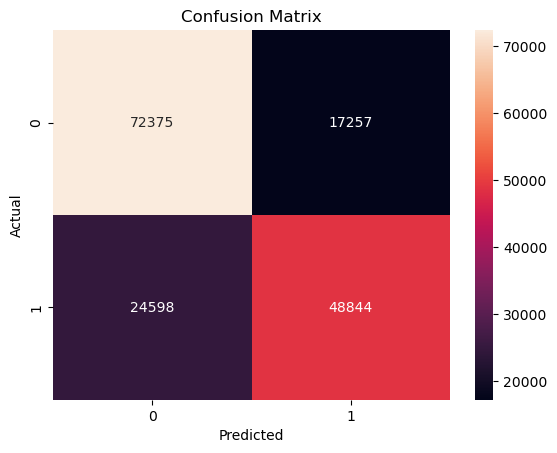

In [28]:
#print confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [31]:
#print the included features with their importances in descending order
sorted_indices = np.argsort(importances[indices])[::-1]
sorted_features = [top_features[i] for i in sorted_indices]
sorted_importances = [importances[indices[i]] for i in sorted_indices]

print('Included Features with Importances: ')
for i in range(len(sorted_features)):
    print(f'{sorted_features[i]}: {sorted_importances[i]}')

Included Features with Importances: 
Bene_Male_Cnt: 0.06409294153145405
Tot_Sbmtd_Chrg: 0.05177767777707465
is_NP: 0.04839365414068573
Tot_Mdcr_Pymt_Amt: 0.04566028914863172
Tot_HCPCS_Cds: 0.04405775794775063
Bene_Feml_Cnt: 0.04188143264329343
has_MD: 0.03459707459833855
Bene_Avg_Risk_Scre: 0.034446761280901635
Med_Tot_Srvcs: 0.033138775740439344
Med_Tot_Benes: 0.03270352150676463
Tot_Benes: 0.03216781866674617
Tot_Srvcs: 0.03195137345214567


In [25]:
#print the encoding for the included categorical features
for feature in categorical_features:
    print(f'{feature}: {list(label_encoders[feature].classes_)}')


Rndrng_Prvdr_RUCA: [1.0, 1.1, 2.0, 2.1, 3.0, 4.0, 4.1, 5.0, 5.1, 6.0, 7.0, 7.1, 7.2, 8.0, 8.1, 8.2, 9.0, 10.0, 10.1, 10.2, 10.3, 99.0]
Rndrng_Prvdr_State_Abrvtn: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
has_MD: [0, 1]
has_DO: [0, 1]
is_NP: [0, 1]
is_PA: [0, 1]
flag_not_MD_DO_NP_PA: [False, True]


One observation: Use of any specific preventive care procedure or immunization was not in the top 12 features on which this model was focused.

In [26]:
#save the model
pkl.dump(best_model, open('model.pkl', 'wb'))